In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np


# Context

In [2]:
df = pd.read_csv('train.csv', index_col=0)

In [3]:
df.shape

(100000, 11)

In [4]:
df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


Описание каждой переменной дано на каггле:


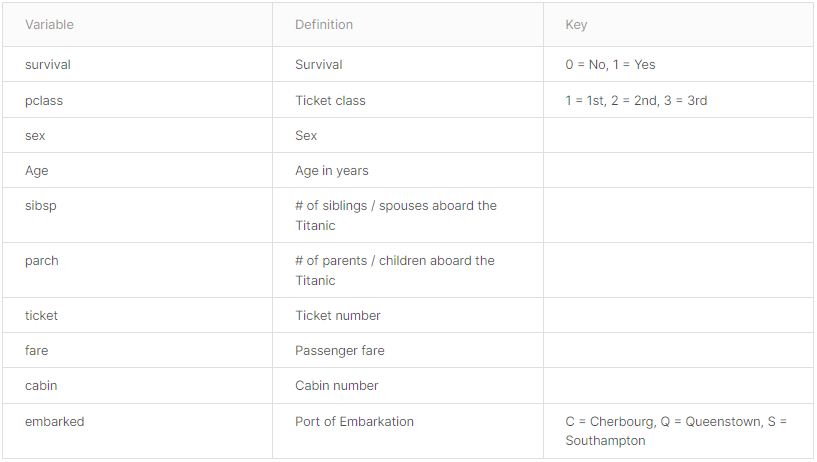

Variable Notes
pclass - класс пассажира: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age - возраст пассажира  Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp - путешествует с родственниками: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch - наличие у пассажира детей/родителей: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [5]:
# оценим датасет
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [6]:
df.isnull().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

In [7]:
# Удалим дубликаты
df.drop_duplicates(keep='first')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


Первоначально оценим фичи, которые содержат пропуски и заполним их валидными данными: Age, Ticket, Fare, Cabin, Embarked

Cabin содержит очень много пропусков, заполнить данные не представляется возможным, т.к. номер кабины не зависит от других фичей, удалим данную фичу. 

Embarked - по моему мнению порт посадки никоим образом не повлияет на выживаемость пассажира, следоавтельно также удалим

In [8]:
df.drop(columns = ['Cabin', 'Embarked'], inplace=True)

Age оценим на основании класса, пола, наличие родственников

Родственники:

In [9]:
df[(df['Parch'] > 0) | (df['SibSp'] > 0)]['Survived'].value_counts() / df[(df['Parch'] > 0) | (df['SibSp'] > 0)]['Survived'].shape[0]

0    0.534406
1    0.465594
Name: Survived, dtype: float64

In [10]:
df[(df['Parch'] == 0) & (df['SibSp'] == 0)]['Survived'].value_counts() / df[(df['Parch'] == 0) & (df['SibSp'] == 0)]['Survived'].shape[0]

0    0.595606
1    0.404394
Name: Survived, dtype: float64

Как мы видим между наличие родственников на корабле и выживаемости слабая корреляция. Следовательно добавим отдельную фичу  переменную 'Relative' 1 - есть, 0 - нет. Также из-за разной интерпретации обозначения ребенок/жена, ребенок/родитель невозможно разгарничить пассажиров без возраста на детей и взрослых

In [11]:
df['Relative'] = np.where((df['Parch'] == 0) & (df['SibSp'] == 0), 0, 1)

In [12]:
df.drop(columns=['SibSp', 'Parch'], inplace=True)

Посмотрим на Пол и Класс

In [13]:
df.groupby('Sex')['Survived'].apply(lambda x: f'{x.sum()/len(x)*100: 0.2f} % ({x.sum()}/{len(x)})')

Sex
female     71.15 % (31226/43886)
male       20.58 % (11548/56114)
Name: Survived, dtype: object

In [14]:
x = list(df.groupby('Sex')['Survived'].apply(lambda x: x.sum()/len(x)*100).index)
y = df.groupby('Sex')['Survived'].apply(lambda x: x.sum()/len(x)*100).values

C:\Users\chechuhae\anaconda3\envs\for_tests\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

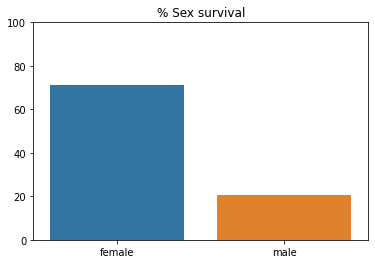

In [15]:
sns.barplot(x, y)
plt.title('% Sex survival')
plt.ylim([0, 100])

In [16]:
df.groupby('Pclass')['Survived'].apply(lambda x: f'{x.sum()/len(x)*100: 0.2f} % ({x.sum()}/{len(x)})')

Pclass
1     57.98 % (17576/30315)
2     52.50 % (15057/28679)
3     24.73 % (10141/41006)
Name: Survived, dtype: object

In [17]:
x = list(df.groupby('Pclass')['Survived'].apply(lambda x: x.sum()/len(x)*100).index)
y = df.groupby('Pclass')['Survived'].apply(lambda x: x.sum()/len(x)*100).values

C:\Users\chechuhae\anaconda3\envs\for_tests\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

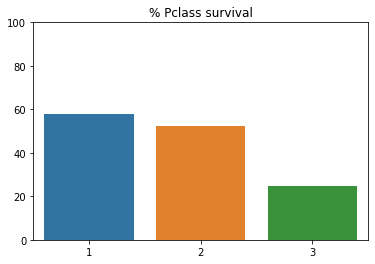

In [18]:
sns.barplot(x, y)
plt.title('% Pclass survival')
plt.ylim([0, 100])

Видим очень сильную корреляцию выживаемости с классом и полом, поэтому

Age, заполним значениями медианы, т.к. она меньше подвержена выбросам, в зависимости от класса пассажира и пола, без учета наличия родственников

In [19]:
conditions = [(df['Age'].isnull() == True) & (df['Sex'] == 'male') & (df['Pclass'] == 1), 
              (df['Age'].isnull() == True) & (df['Sex'] == 'male') & (df['Pclass'] == 2), 
              (df['Age'].isnull() == True) & (df['Sex'] == 'male') & (df['Pclass'] == 3), 
              (df['Age'].isnull() == True) & (df['Sex'] == 'female') & (df['Pclass'] == 1),
              (df['Age'].isnull() == True) & (df['Sex'] == 'female') & (df['Pclass'] == 2),
              (df['Age'].isnull() == True) & (df['Sex'] == 'female') & (df['Pclass'] == 3)]
choselist = [df[(df['Sex'] == 'male') & (df['Pclass'] == 1)]['Age'].median(), 
             df[(df['Sex'] == 'male') & (df['Pclass'] == 2)]['Age'].median(), 
             df[(df['Sex'] == 'male') & (df['Pclass'] == 3)]['Age'].median(),
             df[(df['Sex'] == 'female') & (df['Pclass'] == 1)]['Age'].median(),
             df[(df['Sex'] == 'female') & (df['Pclass'] == 2)]['Age'].median(),
             df[(df['Sex'] == 'female') & (df['Pclass'] == 3)]['Age'].median()]

In [20]:
df['Age'] = np.select(conditions, choselist, default=df['Age']) 

Далее разобьем людей на возрастные группы и поиграемся с бинами, чтобы оценить группу

In [21]:
bins = [-np.inf, 18, 30, 40, 50, 60, np.inf]
# задаем метки для категорий будущей переменной
group_names = ['0-18', '18-30', '30-40', '40-50', '50-60', '<60']
# осуществляем биннинг переменной
df['Age_cat'] = pd.cut(df['Age'], bins, labels=group_names)

In [22]:
df.groupby('Age_cat')['Survived'].apply(lambda x: f'{x.sum()/len(x)*100: 0.2f} % ({x.sum()}/{len(x)})')

Age_cat
0-18      43.13 % (5448/12633)
18-30     34.02 % (7934/23325)
30-40     37.53 % (6594/17570)
40-50     48.03 % (8097/16857)
50-60     47.02 % (8438/17944)
<60       53.66 % (6263/11671)
Name: Survived, dtype: object

In [23]:
x = list(df.groupby('Age_cat')['Survived'].apply(lambda x: x.sum()/len(x)*100).index)
y = df.groupby('Age_cat')['Survived'].apply(lambda x: x.sum()/len(x)*100).values

C:\Users\chechuhae\anaconda3\envs\for_tests\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

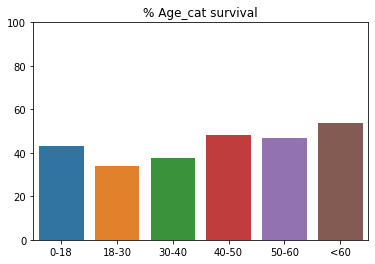

In [24]:
sns.barplot(x, y)
plt.title('% Age_cat survival')
plt.ylim([0, 100])

Корреляция между возрастом и выживаемостью высокая, оставим бины на данном уровне.

Ticket - это номер билета, у каждого он был свой, поэтому данную фичу удалю, т.к. она не несет в себе смысловой нагрузки, никакую зависимость выживаемости не имеет, ниже количество уникальных значений.

In [25]:
df.Ticket.unique().shape[0]

75332

In [26]:
df.drop(columns = 'Ticket', inplace=True)

In [27]:
# также дропнем имена
df = df.drop(columns = ['Name'])

Fare посмотрим на выбросы, далее скорректируем их медианным значением по каждому классу. Т.к. 2 класс не может стоить дороже первого, то все запредельные суммы тарифа по первому классу оставим неизменными. Далее заполним пропуски и разобьем наши тарифы на группы и оценим выживших

C:\Users\chechuhae\anaconda3\envs\for_tests\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fare'>

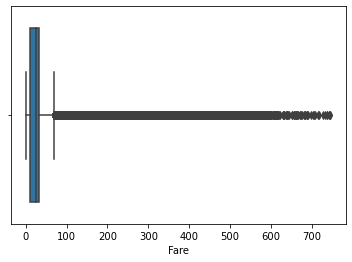

In [28]:
sns.boxplot(df.Fare)

In [29]:
df[(df['Fare'] >= df['Fare'].quantile([0.75]).values[0]) & (df['Pclass'] != 1)]

,Survived,Pclass,Sex,Age,Fare,Relative,Age_cat
PassengerId,,,,,,,
2,0,3,male,0.33,71.29,1,0-18
34,1,2,female,40.00,33.66,0,30-40
43,0,2,male,23.00,35.18,1,18-30
51,0,2,female,47.00,72.45,1,40-50
55,0,3,male,3.00,80.84,1,0-18
...,...,...,...,...,...,...,...
99926,1,3,female,8.00,73.69,1,0-18
99935,1,2,male,30.00,75.60,0,18-30
99938,0,2,female,28.00,36.94,0,18-30


In [30]:
conditions = [(df['Fare'] >= df['Fare'].quantile([0.75]).values[0]) & (df['Pclass'] == 3), 
              (df['Fare'] >= df['Fare'].quantile([0.75]).values[0]) & (df['Pclass'] == 2),
              (df['Fare'].isnull() == True) & (df['Pclass'] == 3), 
              (df['Fare'].isnull() == True) & (df['Pclass'] == 2)]
choselist = [df[(df['Fare'] >= df['Fare'].quantile([0.75]).values[0]) & (df['Pclass'] == 3)]['Fare'].median(), 
             df[(df['Fare'] >= df['Fare'].quantile([0.75]).values[0]) & (df['Pclass'] == 2)]['Fare'].median(), 
             df[df['Pclass'] == 3]['Fare'].median(), 
             df[df['Pclass'] == 2]['Fare'].median()] 

In [31]:
df['Fare'] = np.select(conditions, choselist, default=df['Fare']) 

In [32]:
bins = [-np.inf, 30, 50, 70, 100, np.inf]
# задаем метки для категорий будущей переменной
group_names = ['0-30', '30-50', '50-70', '70-100', '<100']
# осуществляем биннинг переменной
df['Fare_cat'] = pd.cut(df['Fare'], bins, labels=group_names)

Сравнив два варианта корректировки столбца тариф получили вывод, что необходимо только заполнить пропуски, а выбросы оставить как есть. Т.к. 

с корректировкой выбросов

df.groupby('Fare_cat')['Survived'].apply(lambda x: f'{x.sum()/len(x)*100: 0.2f} % ({x.sum()}/{len(x)})')

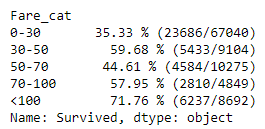

In [33]:
# без корректировкой выбросов
df.groupby('Fare_cat')['Survived'].apply(lambda x: f'{x.sum()/len(x)*100: 0.2f} % ({x.sum()}/{len(x)})')

Fare_cat
0-30       35.33 % (23686/67040)
30-50        59.67 % (5443/9122)
50-70       44.59 % (4574/10257)
70-100       57.95 % (2810/4849)
<100         71.76 % (6237/8692)
Name: Survived, dtype: object

In [34]:
x = list(df.groupby('Fare_cat')['Survived'].apply(lambda x: x.sum()/len(x)*100).index)
y = df.groupby('Fare_cat')['Survived'].apply(lambda x: x.sum()/len(x)*100).values

C:\Users\chechuhae\anaconda3\envs\for_tests\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 100.0)

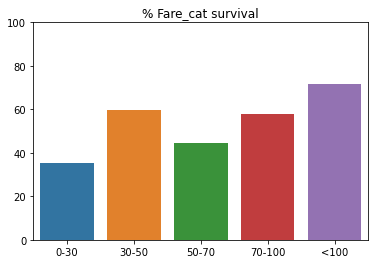

In [35]:
sns.barplot(x, y)
plt.title('% Fare_cat survival')
plt.ylim([0, 100])

Также видим, что тариф аналогично класса влияет на выживаемость пассажира.

# Summary

Вывод таков, что выживаемость пассажира сильно зависит от возвраста, тарифа/класса, а также пола.
Выживаеомсть слабо зависит от нахождения на борту "родтсвенников", номера билета/каюты. порта посадки.